In [1]:
from notebook.services.config import ConfigManager
cfgm = ConfigManager()
cfgm.update('livereveal', {
              'theme': 'simple',
              'transition': 'convex',
              'start_slideshow_at': 'selected'
});

In [2]:
from IPython.core.display import HTML
HTML("""<style>
.answers { 
    visibility: hidden;
}
</style>""")

In [3]:
%pylab inline
%cd working

Populating the interactive namespace from numpy and matplotlib
/Users/barronh/Development/RAQMSandPython/working


# Python Emissions Modification

Presented by: Barron H. Henderson, Byeong-Uk Kim

# CMAQ Area:
## Emissions Perturbation

1. Copy a standard emissions input file
2. Open the file in edit mode
3. Change the concentration (e.g., cut NOx by half)
4. Close the file

# CMAQ Area:
## Prepare by getting data

In [4]:
from urllib.request import urlretrieve, url2pathname
import os
qemisurl = 'ftp://data.as.essie.ufl.edu/pub/exch/CMAQandPython/' +\
           'cmaq/emis_mole_all_20060801_12US1_cmaq_cb05_tx_C25_2006am.nc4'
qemisoldpath = os.path.join('cmaq', os.path.basename(qemisurl))
if not os.path.exists(qemisoldpath):
    urlretrieve(qemisurl, filename = qemisoldpath)


# CMAQ Area:
## Copy a existing file

1. Easies way
2. You can also create your own from scratch

In [5]:
emisoldpath = 'cmaq/emis_mole_all_20060801_12US1_cmaq_cb05_tx_C25_2006am.nc4'
emisnewpath = 'emis_cmaq_new.nc'

In [6]:
import shutil
shutil.copyfile(emisoldpath, emisnewpath)

'emis_cmaq_new.nc'

# CMAQ Area:
## Open the new file in edit mode

In [7]:
from PseudoNetCDF import PNC
emisargs = PNC('--format=netcdf,mode="r+"', emisnewpath)
emisnewfile = emisargs.ifiles[0]

# CMAQ Area:
## Across the Board Cuts

In [8]:
emisnewfile.variables['NO'][:] /= 2
emisnewfile.variables['NO2'][:] /= 2

In [9]:
emisnewfile.history = getattr(emisnewfile, 'history', '')
emisnewfile.history += 'NOx / 2 everywhere; '
emisnewfile.close()

# CMAQ Area:
## reopen and verify

In [10]:
emisargs = PNC("--format=netcdf", emisoldpath, emisnewpath)
oldfile, newfile = emisargs.ifiles
print('SPC    OLD    NEW UNITS')
Mw = dict(NO = 30, NO2 = 46) # g/mole
t2h = 3600
g2Mg = 1e-6
for k in 'NO NO2'.split():
    old = oldfile.variables[k][:].sum()*t2h*g2Mg*Mw[k]
    new = newfile.variables[k][:].sum()*t2h*g2Mg*Mw[k]
    print('%3s %6.1f %6.1f Mg/day' % (k, old, new))

print(newfile.history)
newfile.close()

SPC    OLD    NEW UNITS
 NO 5127.8 2563.9 Mg/day
NO2  809.8  404.9 Mg/day
emis_cmaq_new.nc;--format=netcdf,mode="r+" emis_cmaq_new.nc;NOx / 2 everywhere; 


# CMAQ Area: site-specific

You can also make modifications at specific sites in the area emissions.

In [11]:
from PseudoNetCDF.coordutil import getproj4
import pyproj
lons = [-79.0558, -84.388]
lats = [35.9132, 33.7499]
proj4str = getproj4(oldfile, withgrid = True)
print(proj4str)
proj = pyproj.Proj(proj4str, preserve_units = True)
emisargs = PNC('--format=netcdf,mode="r+"', emisnewpath)
emisnewfile = emisargs.ifiles[0]
emisnewfile.history = getattr(emisnewfile, 'history', '')
for lon, lat in zip(lons, lats):
    x, y = proj(lon, lat)
    i, j = np.int64(x), np.int64(y)
    print(lon, lat)
    emisnewfile.history += 'Updating NOx (*=100) at i=%d j=%d *= 10; ' % (i,j)
    emisnewfile.variables['NO'][:, :, j, i] *= 100
    emisnewfile.variables['NO2'][:, :, j, i] *= 100

emisnewfile.close()

+proj=lcc +a=6370000.0 +b=6370000.0 +lon_0=-97.0 +lat_1=33.0 +lat_2=45.0 +lat_0=40.0 +x_0=-504000.0 +y_0=1488000.0 +to_meter=12000.0m +no_defs
-79.0558 35.9132
-84.388 33.7499


# Reopen and Verify

In [12]:
emisargs = PNC("--format=netcdf", emisoldpath, emisnewpath)
oldfile, newfile = emisargs.ifiles
print('SPC    OLD    NEW UNITS')
Mw = dict(NO = 30, NO2 = 46) # g/mole
t2h = 3600
g2Mg = 1e-6
for k in 'NO NO2'.split():
    old = oldfile.variables[k][:].sum()*t2h*g2Mg*Mw[k]
    new = newfile.variables[k][:].sum()*t2h*g2Mg*Mw[k]
    print('%3s %6.1f %6.1f Mg/day' % (k, old, new))

print(newfile.history)
newfile.close()

SPC    OLD    NEW UNITS
 NO 5127.8 3449.7 Mg/day
NO2  809.8  544.8 Mg/day
emis_cmaq_new.nc;--format=netcdf,mode="r+" emis_cmaq_new.nc;NOx / 2 everywhere; emis_cmaq_new.nc;--format=netcdf,mode="r+" emis_cmaq_new.nc;Updating NOx (*=100) at i=91 j=99 *= 10; Updating NOx (*=100) at i=54 j=73 *= 10; 


# Check Point

Were site-wide and specific site changes additive? (answer hidden)
<div class="answers">
Yes. Files can be iteratively opened and modified. It is good to edit the history so you can check!

1. You can check by rerunning confirmation of mass update.
2. You can check via history property.
</div>

# CAMx Area

Repeat the CMAQ process with two exceptions:
1. use uamiv instead of netcdf
2. remove the change t2h from 3600 (what should it be?)

In [13]:
from urllib.request import urlretrieve, url2pathname
import os
xemisurl = 'ftp://data.as.essie.ufl.edu/pub/exch/CMAQandPython/camx/emiss.stl.36km.20020603.a1.bin'
xemisoldpath = os.path.join('camx', os.path.basename(xemisurl))
if not os.path.exists(xemisoldpath):
    urlretrieve(xemisurl, filename = xemisoldpath)

# CAMx Point: Emissions Perturbation

1. Modify existing emissions
2. Add a new point

# CAMx Point:
## Prepare by downloading some data

In [14]:
from urllib.request import urlretrieve, url2pathname
import os
xemisurl = 'ftp://data.as.essie.ufl.edu/pub/exch/CMAQandPython/camx/camx_point_test.bin'
xemisoldpath = os.path.join('camx', os.path.basename(qemisurl))
if not os.path.exists(qemisoldpath):
    urlretrieve(xemisurl, filename = xemisoldpath)


In [15]:
oldxpntpath = 'camx/camx_point_test.bin'
newxpntpath = 'camx_point_new.bin'
doublexpntpath = 'camx_point_2x.bin'

# CAMx Point: Double NOx

1. Copy input
2. Read in
3. Double NO and NO2

In [16]:
# Copy input
import shutil
shutil.copyfile(oldxpntpath, doublexpntpath)
# Read in edit mode, double save
from PseudoNetCDF import PNC
doubleargs = PNC('--format=point_source,mode="r+"', doublexpntpath)
doublefile = doubleargs.ifiles[0]
doublefile.variables['NO'][:] *= 2
doublefile.variables['NO2'][:] *= 2
doublefile.history += '; doubling NO and NO2 everywhere'
doublefile.close()

# CAMx Point:
## Reopen and verify

In [17]:
emisargs = PNC("--format=point_source", oldxpntpath, doublexpntpath)
oldfile, newfile = emisargs.ifiles
print('SPC    OLD    NEW UNITS')
Mw = dict(NO = 30, NO2 = 46) # g/mole
t2h = 3600
g2Mg = 1e-6
for k in 'NO NO2'.split():
    old = oldfile.variables[k][:].sum()*t2h*g2Mg*Mw[k]
    new = newfile.variables[k][:].sum()*t2h*g2Mg*Mw[k]
    print('%3s %6.1f %6.1f Mg/day' % (k, old, new))

print(newfile.history)
newfile.close()

SPC    OLD    NEW UNITS
 NO  735.0 1470.0 Mg/day
NO2  125.2  250.4 Mg/day
camx/camx_point_test.bin camx_point_2x.bin;--format=point_source camx/camx_point_test.bin camx_point_2x.bin;


# CAMx Point: Adding a point

1. Review the basic file
2. Create a template for holding results
3. Define new points
4. Add new point data

# CAMx Point: Add new
## Review the basic file
 
1. dimensions,
2. properties,
3. variables (and their properties)


In [18]:
from PseudoNetCDF.pncgen import Pseudo2NetCDF, pncgen
p2n = Pseudo2NetCDF()
pntargs = PNC('--format=point_source', doublexpntpath)
infile = pntargs.ifiles[0]
infile

PseudoNetCDF.camxfiles.point_source.Memmap.point_source unknown {
dimensions:
        NSTK = 5 ;
        TSTEP = 2 ;
        DATE-TIME = 2 ;
        VAR = 26 ;

variables:
        float NH3(TSTEP, NSTK);
                NH3:units = "mole/hr         " ;
                NH3:long_name = "NH3             " ;
                NH3:var_desc = "NH3             " ;
        integer IONE(TSTEP, NSTK);
                IONE:units = "#" ;
                IONE:long_name = "IONE            " ;
                IONE:var_desc = "IONE            " ;
        float OLE(TSTEP, NSTK);
                OLE:units = "mole/hr         " ;
                OLE:long_name = "OLE             " ;
                OLE:var_desc = "OLE             " ;
        float CPRM(TSTEP, NSTK);
                CPRM:units = "mole/hr         " ;
                CPRM:long_name = "CPRM            " ;
                CPRM:var_desc = "CPRM            " ;
        float YSTK(NSTK);
                YSTK:units = "m" ;
                YSTK:long_na

# CAMx Point: Add new
## Template for new results

1. Make a new output file
2. Copy dimensions (except NSTK = NSTK + 2)
3. Copy global properties
4. Copy variables with old variable data

# CAMx Point: New Points
## Make empty file

In [19]:
from PseudoNetCDF import PseudoNetCDFFile
outfile = PseudoNetCDFFile()

# CAMx Point: Add new
## Copy and augment dimensions

In [20]:
for dimkey, dimo in infile.dimensions.items():
    if dimkey == 'NSTK':
        dimlen =  7
    else:
        dimlen = len(dimo)
    
    outfile.createDimension(dimkey, dimlen)

# CAMx Point: Add new
## Copy global properties

In [21]:
for key in infile.ncattrs():
    setattr(outfile, key, getattr(infile, key))

# CAMx Point: Add new
## Copy variables (old data)

In [22]:
for vark, invar in infile.variables.items():
    outvar = outfile.createVariable(vark,
                                    invar.dtype.char,
                                    invar.dimensions)
    for key in invar.ncattrs():
        setattr(outvar, key, getattr(invar, key))

    # (NSTK,) per stack Variables 
    if outvar.ndim == 1:
        outvar[:5] = invar[:]
    # (TSTEP,VAR,DATE-TIME) - TFLAG
    elif outvar.ndim == 3:
        outvar[:] = invar[:]
    # (TSTEP, NSTK)
    else:
        outvar[:, :5] = invar[:, :]

# CAMx Point: Add new
## Project Some New Points

In [23]:
from PseudoNetCDF.coordutil import getproj4
from pyproj import Proj
projin = Proj('+proj=lcc +a=6370000.0 +b=6370000.0 +lon_0=-97.0 +lat_1=33.0 +lat_2=45.0 +lat_0=40.0 +no_defs', preserve_unit = True)
lons = [-79.0558, -84.388]
lats = [35.9132, 33.7499]
stkX, stkY = projin(lons, lats)
stkX, stkY

([1598890.4622295578, 1160661.755702475],
 [-293680.26196647936, -611235.3333806654])

# CAMx Point: Add new
## Set the time-independent properties
- XSTK, YSTK location in projected coordinates (meters)
- HSTK, DSTK height and diameter in (meters)
- TSTK, VSTK temperature (K) and velocity (m/hr)

In [24]:
# Stack Properties ['XSTK','YSTK','HSTK','DSTK','TSTK','VSTK']
outfile.variables['XSTK'][5:] = stkX
outfile.variables['YSTK'][5:] = stkY
outfile.variables['HSTK'][5:] = 100.
outfile.variables['DSTK'][5:] = 1.
outfile.variables['TSTK'][5:] = 400.
outfile.variables['VSTK'][5:] = 150000.

# Time-dependent Stack Properties
* IONE, ITWO - dummy variables
* KCELL - if negative, OSAT/PSAT override
* FLOW - flow rate m$^3$/hr
* PLMHT - negative values override plumerise

In [25]:
# Time-dependent Stack Props ['IONE','ITWO','KCELL','FLOW','PLMHT']
outfile.variables['IONE'][:,5:] = 0
outfile.variables['ITWO'][:,5:] = 0
outfile.variables['KCELL'][:,5] = 1
outfile.variables['FLOW'][:,5] = 0.
outfile.variables['PLMHT'][:,5] = 0.

# Add new point emissions

In [26]:
# Emissions ['ALD2', 'CO', 'CPRM', 'ETH', 'FORM', 'FPRM', 'ISOP', 'NH3', 'NO', NO2', 'NR', 'OLE', 'PAR', 'PEC', 'PNO3', 'POA', 'PSO4', 'SO2', 'SULF', 'TOL', 'TOLA', 'XYL', 'XYLA']
outfile.variables['NO'][:,5:] = outfile.variables['NO'][:].mean(1)
outfile.variables['NO2'][:,5:] = outfile.variables['NO'][:].mean(1)

# Write out the file

1. Notice pncgen could be used for persisting any file
2. Formats for writing include (NetCDF3/4, camx uamiv, etc)

In [27]:
pncgen(outfile, newxpntpath, format = 'point_source');

In [28]:
pntargs = PNC('--format=point_source', newxpntpath)
outfile = pntargs.ifiles[0]
outfile

PseudoNetCDF.camxfiles.point_source.Memmap.point_source unknown {
dimensions:
        NSTK = 7 ;
        TSTEP = 2 ;
        DATE-TIME = 2 ;
        VAR = 26 ;

variables:
        float NH3(TSTEP, NSTK);
                NH3:units = "mole/hr         " ;
                NH3:long_name = "NH3             " ;
                NH3:var_desc = "NH3             " ;
        integer IONE(TSTEP, NSTK);
                IONE:units = "#" ;
                IONE:long_name = "IONE            " ;
                IONE:var_desc = "IONE            " ;
        float OLE(TSTEP, NSTK);
                OLE:units = "mole/hr         " ;
                OLE:long_name = "OLE             " ;
                OLE:var_desc = "OLE             " ;
        float CPRM(TSTEP, NSTK);
                CPRM:units = "mole/hr         " ;
                CPRM:long_name = "CPRM            " ;
                CPRM:var_desc = "CPRM            " ;
        float YSTK(NSTK);
                YSTK:units = "m" ;
                YSTK:long_na

# Plotting CAMx Point Source Files

1. Create an appropriate basemap
2. Convert projected coordinates to basemap coordinates
    * basemap coordinates are map extent dependent
    * XSTK, YSTK are relative to XORIG/YORIG
3. Plot emissions using colors or sizes
4. Add features including WGS84 ArcGIS shapefiles
5. Save to disk

# Create appropriate basemap

In [29]:
from mpl_toolkits.basemap import Basemap
bmap = Basemap(projection='lcc', rsphere = (6370000.0,6370000.0),
               lon_0=-97.0, lat_1=33.0, lat_2=45.0, lat_0=40.0,
               llcrnrlon = -95, llcrnrlat = 25, urcrnrlon= -70, urcrnrlat = 40,
               resolution = 'c')
# Notice offset problem
bmap(-95, 25), bmap(-70, 40)

((0.0, 0.0), (2047450.7147794622, 2008729.5497043761))

# Project XSTK/YSTK to lon/lat

In [30]:
# project infile and outfile lon/lat
from pyproj import Proj
projin = Proj('+proj=lcc +a=6370000.0 +b=6370000.0 ' +
              '+lon_0=-97.0 +lat_1=33.0 +lat_2=45.0 ' +
              '+lat_0=40.0 +no_defs',
              preserve_unit = True)
islon, islat = projin(infile.variables['XSTK'][:],
                      infile.variables['YSTK'][:], inverse = True)
oslon, oslat = projin(outfile.variables['XSTK'][:],
                      outfile.variables['YSTK'][:], inverse = True)

# CAMx Point: Plot
## Calculate color or size parameter

In [31]:
# calculate mean NO
inoxmean = infile.variables['NO'][:].mean(0) + infile.variables['NO2'][:].mean(0)
onoxmean = outfile.variables['NO'][:].mean(0) + outfile.variables['NO2'][:].mean(0)

# CAMx Point: Plot
## Create plot

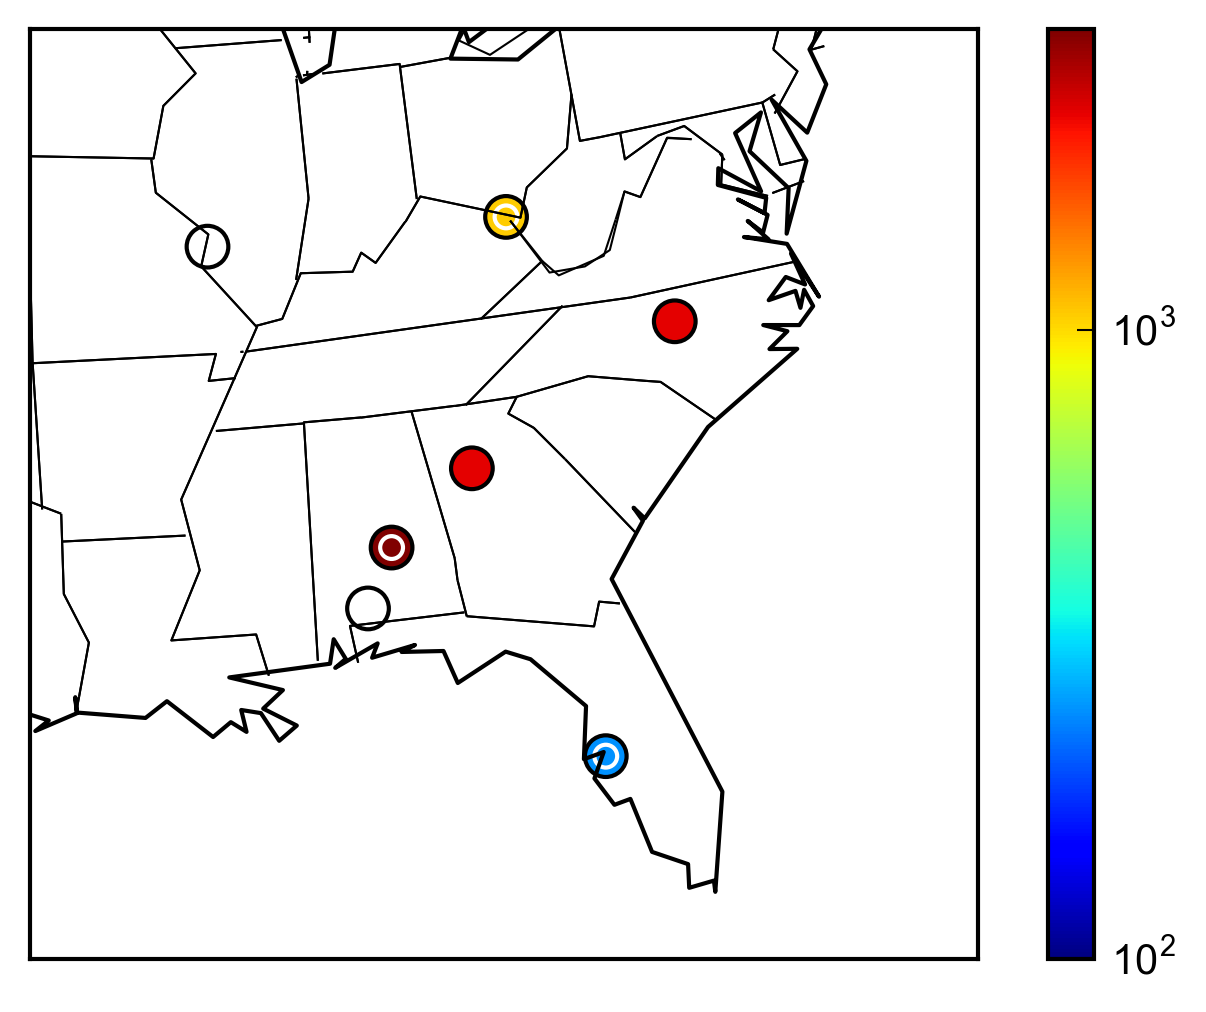

In [32]:
norm = plt.matplotlib.colors.LogNorm(100, 3000)
bmap.scatter(oslon, oslat, c = onoxmean, s = 100, edgecolor = 'k', norm = norm, latlon = True)
bmap.scatter(islon, islat, c = inoxmean, s = 30, edgecolor = 'white', norm = norm, latlon = True)
plt.colorbar()
bmap.drawcoastlines()
bmap.drawcountries()
bmap.drawstates();